# Supervised Churn Prediction Modeling

**Author:** Harpinder Singh  
**Dataset:** UK E-Commerce Customer Features  
**Objective:** Build and compare supervised models for churn prediction

---

## Table of Contents
1. [Environment Setup](#1.-Environment-Setup)
2. [Load Features & Prepare Data](#2.-Load-Features-&-Prepare-Data)
3. [Train-Test Split](#3.-Train-Test-Split)
4. [Baseline Models](#4.-Baseline-Models)
5. [Advanced Models](#5.-Advanced-Models)
6. [Model Comparison](#6.-Model-Comparison)
7. [Hyperparameter Tuning](#7.-Hyperparameter-Tuning)
8. [Final Model Selection](#8.-Final-Model-Selection)
9. [Export Results](#9.-Export-Results)

---

## 1. Environment Setup

╔════════════════════════════════════════════════════════════════╗
║                    ENVIRONMENT CONFIGURATION                    ║
╚════════════════════════════════════════════════════════════════╝

In [1]:
# Standard imports
import warnings
from pathlib import Path
import time

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# ML imports
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report, precision_recall_curve, roc_curve
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

# Model persistence
import pickle

# Configuration
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{x:.4f}')

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Environment configured")

✅ Environment configured


In [2]:
# ┌────────────────────────────────────────────────────────────┐
# │ Directory Setup                                            │
# └────────────────────────────────────────────────────────────┘

PROJECT_ROOT = Path.cwd()
if PROJECT_ROOT.name == 'notebooks':
    PROJECT_ROOT = PROJECT_ROOT.parent

DIR_DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
DIR_MODELS = PROJECT_ROOT / 'models'
DIR_RESULTS = PROJECT_ROOT / 'results'
DIR_FIGURES = PROJECT_ROOT / 'results' / 'figures'

for directory in [DIR_MODELS, DIR_RESULTS, DIR_FIGURES]:
    directory.mkdir(parents=True, exist_ok=True)

print("✅ Directories ready")

✅ Directories ready


---

## 2. Load Features & Prepare Data

╔════════════════════════════════════════════════════════════════╗
║                      DATA LOADING                               ║
╚════════════════════════════════════════════════════════════════╝

In [3]:
# ┌────────────────────────────────────────────────────────────┐
# │ Load Engineered Features                                   │
# └────────────────────────────────────────────────────────────┘

# Load features from Phase 3
data = pd.read_csv(DIR_DATA_PROCESSED / 'churn_features.csv')

print("Dataset Overview:")
print("="*80)
print(f"Shape: {data.shape}")
print(f"Churn rate: {data['churned'].mean()*100:.1f}%")
print(f"\nClass distribution:")
print(data['churned'].value_counts())

# Separate features and target
X = data.drop(['CustomerID', 'churned'], axis=1)
y = data['churned']

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeature columns:")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

Dataset Overview:
Shape: (815, 32)
Churn rate: 26.9%

Class distribution:
churned
0    596
1    219
Name: count, dtype: int64

Features shape: (815, 30)
Target shape: (815,)

Feature columns:
   1. Recency
   2. Frequency
   3. Monetary
   4. Tenure
   5. AvgOrderValue
   6. AvgBasketSize
   7. prob_alive
   8. predicted_purchases_30d
   9. predicted_purchases_90d
  10. predicted_purchases_180d
  11. predicted_avg_value
  12. CLV_90d
  13. CLV_180d
  14. CLV_365d
  15. revenue_velocity
  16. quantity_velocity
  17. purchase_gap_velocity
  18. early_period_revenue
  19. late_period_revenue
  20. revenue_trend
  21. day_of_week_diversity
  22. weekend_purchase_ratio
  23. purchase_gap_mean
  24. purchase_gap_std
  25. purchase_gap_cv
  26. purchase_regularity
  27. unique_products
  28. avg_items_per_order
  29. product_diversity_ratio
  30. product_exploration_rate


---

## 3. Train-Test Split

╔════════════════════════════════════════════════════════════════╗
║                   TRAIN-TEST SPLIT                              ║
╚════════════════════════════════════════════════════════════════╝

In [4]:
# ┌────────────────────────────────────────────────────────────┐
# │ Split Data                                                 │
# └────────────────────────────────────────────────────────────┘

# 70-30 split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Data Split:")
print("="*80)
print(f"Training set: {X_train.shape[0]} samples")
print(f"  Active: {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.1f}%)")
print(f"  Churned: {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.1f}%)")

print(f"\nTest set: {X_test.shape[0]} samples")
print(f"  Active: {(y_test == 0).sum()} ({(y_test == 0).sum()/len(y_test)*100:.1f}%)")
print(f"  Churned: {(y_test == 1).sum()} ({(y_test == 1).sum()/len(y_test)*100:.1f}%)")

Data Split:
Training set: 570 samples
  Active: 417 (73.2%)
  Churned: 153 (26.8%)

Test set: 245 samples
  Active: 179 (73.1%)
  Churned: 66 (26.9%)


In [5]:
# ┌────────────────────────────────────────────────────────────┐
# │ Feature Scaling                                            │
# └────────────────────────────────────────────────────────────┘

# Standardize features (fit on train only)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for easier handling
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Features scaled (StandardScaler)")
print(f"   Mean: {X_train_scaled.mean().mean():.4f}")
print(f"   Std: {X_train_scaled.std().mean():.4f}")

✅ Features scaled (StandardScaler)
   Mean: 0.0000
   Std: 1.0009


---

## 4. Baseline Models

╔════════════════════════════════════════════════════════════════╗
║                    BASELINE MODELS                              ║
╚════════════════════════════════════════════════════════════════╝

### Models:
1. **Logistic Regression** - Linear baseline
2. **Decision Tree** - Simple non-linear baseline

In [6]:
# ┌────────────────────────────────────────────────────────────┐
# │ Model Evaluation Helper Function                          │
# └────────────────────────────────────────────────────────────┘

def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """
    Train and evaluate a classification model.
    
    Parameters
    ----------
    model : estimator
        Sklearn-compatible classifier
    X_train : array-like
        Training features
    X_test : array-like
        Test features
    y_train : array-like
        Training labels
    y_test : array-like
        Test labels
    model_name : str
        Name of the model
    
    Returns
    -------
    dict
        Dictionary containing metrics and predictions
    """
    # Train
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    results = {
        'model_name': model_name,
        'model': model,
        'train_time': train_time,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba),
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    return results

print("✅ Evaluation function defined")

✅ Evaluation function defined


In [7]:
# ┌────────────────────────────────────────────────────────────┐
# │ Model 1: Logistic Regression                              │
# └────────────────────────────────────────────────────────────┘

print("Training Logistic Regression...")

lr_model = LogisticRegression(
    random_state=RANDOM_STATE,
    max_iter=1000,
    class_weight='balanced'  # Handle class imbalance
)

lr_results = evaluate_model(
    lr_model, X_train_scaled, X_test_scaled, y_train, y_test, 
    'Logistic Regression'
)

print("\n✅ Logistic Regression Results:")
print(f"   Accuracy: {lr_results['accuracy']:.4f}")
print(f"   Precision: {lr_results['precision']:.4f}")
print(f"   Recall: {lr_results['recall']:.4f}")
print(f"   F1-Score: {lr_results['f1']:.4f}")
print(f"   ROC-AUC: {lr_results['roc_auc']:.4f}")
print(f"   Train time: {lr_results['train_time']:.2f}s")

Training Logistic Regression...

✅ Logistic Regression Results:
   Accuracy: 0.5633
   Precision: 0.3306
   Recall: 0.6061
   F1-Score: 0.4278
   ROC-AUC: 0.6332
   Train time: 0.06s


In [8]:
# ┌────────────────────────────────────────────────────────────┐
# │ Model 2: Decision Tree                                     │
# └────────────────────────────────────────────────────────────┘

print("Training Decision Tree...")

dt_model = DecisionTreeClassifier(
    random_state=RANDOM_STATE,
    max_depth=5,
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight='balanced'
)

dt_results = evaluate_model(
    dt_model, X_train, X_test, y_train, y_test,  # No scaling needed for trees
    'Decision Tree'
)

print("\n✅ Decision Tree Results:")
print(f"   Accuracy: {dt_results['accuracy']:.4f}")
print(f"   Precision: {dt_results['precision']:.4f}")
print(f"   Recall: {dt_results['recall']:.4f}")
print(f"   F1-Score: {dt_results['f1']:.4f}")
print(f"   ROC-AUC: {dt_results['roc_auc']:.4f}")
print(f"   Train time: {dt_results['train_time']:.2f}s")

Training Decision Tree...

✅ Decision Tree Results:
   Accuracy: 0.4735
   Precision: 0.3179
   Recall: 0.8333
   F1-Score: 0.4603
   ROC-AUC: 0.5747
   Train time: 0.05s


---

## 5. Advanced Models

╔════════════════════════════════════════════════════════════════╗
║                    ADVANCED MODELS                              ║
╚════════════════════════════════════════════════════════════════╝

### Ensemble Models:
3. **Random Forest** - Bagging ensemble
4. **LightGBM** - Gradient boosting (primary)
5. **CatBoost** - Gradient boosting
6. **XGBoost** - Gradient boosting

In [9]:
# ┌────────────────────────────────────────────────────────────┐
# │ Model 3: Random Forest                                     │
# └────────────────────────────────────────────────────────────┘

print("Training Random Forest...")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=RANDOM_STATE,
    class_weight='balanced',
    n_jobs=-1
)

rf_results = evaluate_model(
    rf_model, X_train, X_test, y_train, y_test,
    'Random Forest'
)

print("\n✅ Random Forest Results:")
print(f"   Accuracy: {rf_results['accuracy']:.4f}")
print(f"   Precision: {rf_results['precision']:.4f}")
print(f"   Recall: {rf_results['recall']:.4f}")
print(f"   F1-Score: {rf_results['f1']:.4f}")
print(f"   ROC-AUC: {rf_results['roc_auc']:.4f}")
print(f"   Train time: {rf_results['train_time']:.2f}s")

Training Random Forest...

✅ Random Forest Results:
   Accuracy: 0.6816
   Precision: 0.4000
   Recall: 0.3636
   F1-Score: 0.3810
   ROC-AUC: 0.6423
   Train time: 0.33s


In [10]:
# ┌────────────────────────────────────────────────────────────┐
# │ Model 4: LightGBM                                          │
# └────────────────────────────────────────────────────────────┘

print("Training LightGBM...")

# Calculate scale_pos_weight for imbalance
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

lgbm_model = LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    num_leaves=31,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    verbose=-1
)

lgbm_results = evaluate_model(
    lgbm_model, X_train, X_test, y_train, y_test,
    'LightGBM'
)

print("\n✅ LightGBM Results:")
print(f"   Accuracy: {lgbm_results['accuracy']:.4f}")
print(f"   Precision: {lgbm_results['precision']:.4f}")
print(f"   Recall: {lgbm_results['recall']:.4f}")
print(f"   F1-Score: {lgbm_results['f1']:.4f}")
print(f"   ROC-AUC: {lgbm_results['roc_auc']:.4f}")
print(f"   Train time: {lgbm_results['train_time']:.2f}s")

Training LightGBM...

✅ LightGBM Results:
   Accuracy: 0.6408
   Precision: 0.3036
   Recall: 0.2576
   F1-Score: 0.2787
   ROC-AUC: 0.5856
   Train time: 5.63s


In [11]:
# ┌────────────────────────────────────────────────────────────┐
# │ Model 5: CatBoost                                          │
# └────────────────────────────────────────────────────────────┘

print("Training CatBoost...")

cb_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    verbose=0
)

cb_results = evaluate_model(
    cb_model, X_train, X_test, y_train, y_test,
    'CatBoost'
)

print("\n✅ CatBoost Results:")
print(f"   Accuracy: {cb_results['accuracy']:.4f}")
print(f"   Precision: {cb_results['precision']:.4f}")
print(f"   Recall: {cb_results['recall']:.4f}")
print(f"   F1-Score: {cb_results['f1']:.4f}")
print(f"   ROC-AUC: {cb_results['roc_auc']:.4f}")
print(f"   Train time: {cb_results['train_time']:.2f}s")

Training CatBoost...

✅ CatBoost Results:
   Accuracy: 0.6449
   Precision: 0.3385
   Recall: 0.3333
   F1-Score: 0.3359
   ROC-AUC: 0.6267
   Train time: 0.71s


In [12]:
# ┌────────────────────────────────────────────────────────────┐
# │ Model 6: XGBoost                                           │
# └────────────────────────────────────────────────────────────┘

print("Training XGBoost...")

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    eval_metric='logloss'
)

xgb_results = evaluate_model(
    xgb_model, X_train, X_test, y_train, y_test,
    'XGBoost'
)

print("\n✅ XGBoost Results:")
print(f"   Accuracy: {xgb_results['accuracy']:.4f}")
print(f"   Precision: {xgb_results['precision']:.4f}")
print(f"   Recall: {xgb_results['recall']:.4f}")
print(f"   F1-Score: {xgb_results['f1']:.4f}")
print(f"   ROC-AUC: {xgb_results['roc_auc']:.4f}")
print(f"   Train time: {xgb_results['train_time']:.2f}s")

Training XGBoost...

✅ XGBoost Results:
   Accuracy: 0.6571
   Precision: 0.3269
   Recall: 0.2576
   F1-Score: 0.2881
   ROC-AUC: 0.6165
   Train time: 2.10s


---

## 6. Model Comparison

╔════════════════════════════════════════════════════════════════╗
║                    MODEL COMPARISON                             ║
╚════════════════════════════════════════════════════════════════╝

In [13]:
# ┌────────────────────────────────────────────────────────────┐
# │ Compile Results                                            │
# └────────────────────────────────────────────────────────────┘

all_results = [lr_results, dt_results, rf_results, lgbm_results, cb_results, xgb_results]

# Create comparison DataFrame
comparison_df = pd.DataFrame([
    {
        'Model': r['model_name'],
        'Accuracy': r['accuracy'],
        'Precision': r['precision'],
        'Recall': r['recall'],
        'F1-Score': r['f1'],
        'ROC-AUC': r['roc_auc'],
        'Train Time (s)': r['train_time']
    }
    for r in all_results
]).sort_values('ROC-AUC', ascending=False)

print("Model Comparison:")
print("="*80)
display(comparison_df)

# Save results
comparison_df.to_csv(DIR_RESULTS / 'outputs' / 'model_comparison.csv', index=False)
print("\n✅ Results saved to: model_comparison.csv")

Model Comparison:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC,Train Time (s)
2,Random Forest,0.6816,0.4000,0.3636,0.3810,0.6423,0.3300
0,Logistic Regression,0.5633,0.3306,0.6061,0.4278,0.6332,0.0631
4,CatBoost,0.6449,0.3385,0.3333,0.3359,0.6267,0.7103
5,XGBoost,0.6571,0.3269,0.2576,0.2881,0.6165,2.1042
3,LightGBM,0.6408,0.3036,0.2576,0.2787,0.5856,5.6262
1,Decision Tree,0.4735,0.3179,0.8333,0.4603,0.5747,0.0467



✅ Results saved to: model_comparison.csv


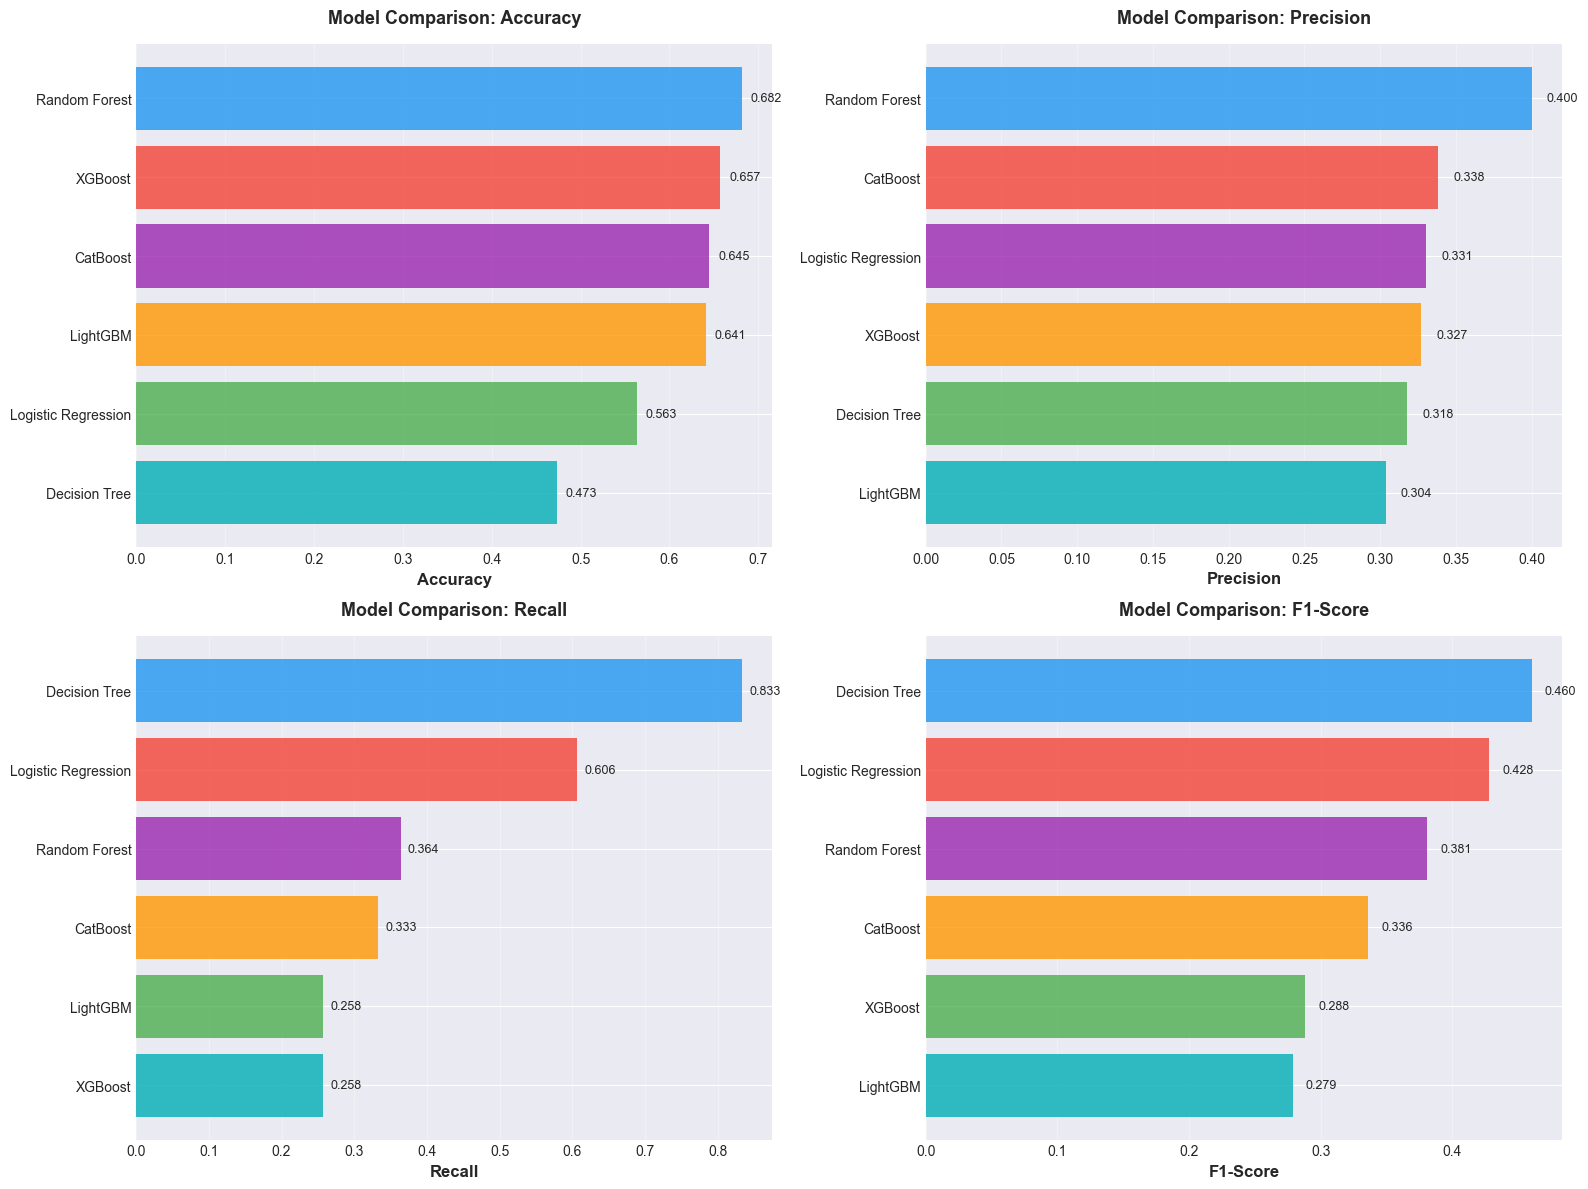

In [14]:
# ┌────────────────────────────────────────────────────────────┐
# │ Visualize Model Comparison                                │
# └────────────────────────────────────────────────────────────┘

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
colors = ['#00ADB5', '#4CAF50', '#FF9800', '#9C27B0', '#F44336', '#2196F3']

for idx, (ax, metric) in enumerate(zip(axes.flat, metrics)):
    data = comparison_df.sort_values(metric, ascending=True)
    ax.barh(range(len(data)), data[metric], color=colors, alpha=0.8)
    ax.set_yticks(range(len(data)))
    ax.set_yticklabels(data['Model'])
    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'Model Comparison: {metric}', fontsize=13, fontweight='bold', pad=15)
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, v in enumerate(data[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '22_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

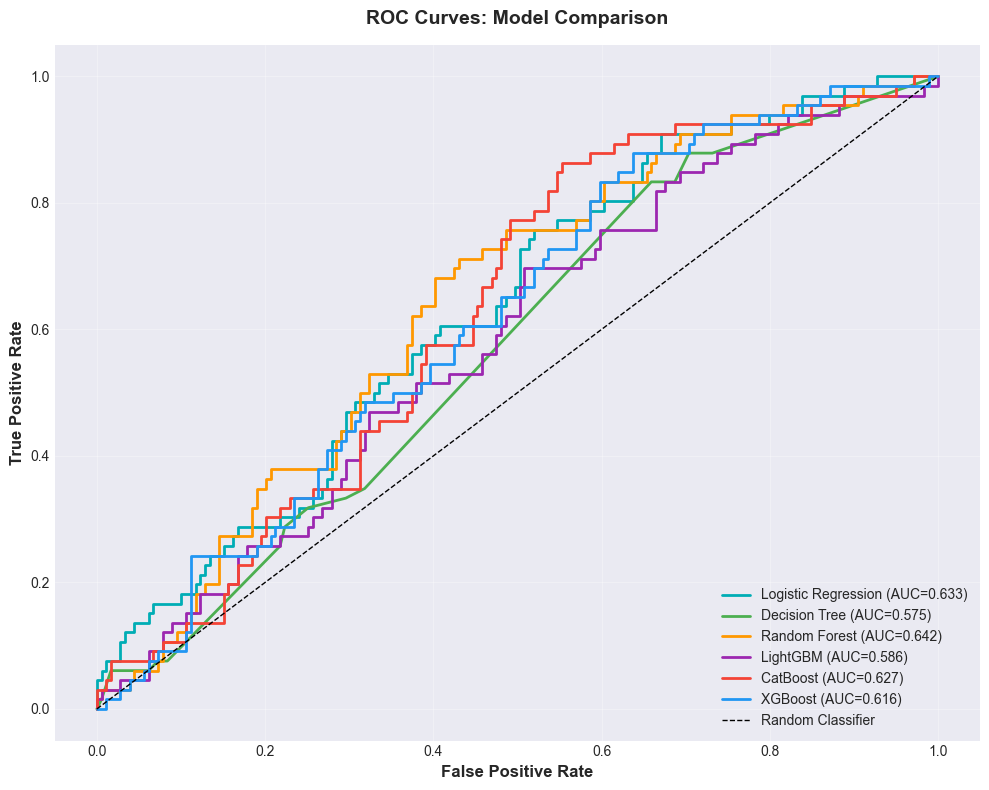

In [15]:
# ┌────────────────────────────────────────────────────────────┐
# │ ROC Curves Comparison                                      │
# └────────────────────────────────────────────────────────────┘

fig, ax = plt.subplots(figsize=(10, 8))

for i, results in enumerate(all_results):
    fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
    ax.plot(fpr, tpr, label=f"{results['model_name']} (AUC={results['roc_auc']:.3f})",
            linewidth=2, color=colors[i])

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random Classifier')
ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax.set_title('ROC Curves: Model Comparison', fontsize=14, fontweight='bold', pad=15)
ax.legend(loc='lower right', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '23_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

---

## 7. Hyperparameter Tuning

╔════════════════════════════════════════════════════════════════╗
║                HYPERPARAMETER TUNING (TOP 2)                    ║
╚════════════════════════════════════════════════════════════════╝

In [16]:
# ┌────────────────────────────────────────────────────────────┐
# │ Select Top 2 Models for Tuning                            │
# └────────────────────────────────────────────────────────────┘

# Get top 2 by ROC-AUC
top_2_models = comparison_df.head(2)['Model'].tolist()

print("Top 2 Models for Hyperparameter Tuning:")
print("="*80)
for i, model_name in enumerate(top_2_models, 1):
    score = comparison_df[comparison_df['Model'] == model_name]['ROC-AUC'].iloc[0]
    print(f"  {i}. {model_name} (ROC-AUC: {score:.4f})")

Top 2 Models for Hyperparameter Tuning:
  1. Random Forest (ROC-AUC: 0.6423)
  2. Logistic Regression (ROC-AUC: 0.6332)


In [17]:
# ┌────────────────────────────────────────────────────────────┐
# │ Tune Best Model (Automatic Selection)                     │
# └────────────────────────────────────────────────────────────┘

best_model_name = top_2_models[0]

print(f"Tuning {best_model_name}...\n")

# Define param grids for different models
if 'LightGBM' in best_model_name:
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'num_leaves': [20, 31, 50],
        'min_child_samples': [10, 20, 30]
    }
    base_model = LGBMClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, verbose=-1)

elif 'CatBoost' in best_model_name:
    param_dist = {
        'iterations': [100, 200, 300],
        'depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1]
    }
    base_model = CatBoostClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, verbose=0)

elif 'XGBoost' in best_model_name:
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [4, 6, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'min_child_weight': [1, 3, 5]
    }
    base_model = XGBClassifier(scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, eval_metric='logloss')

elif 'Random Forest' in best_model_name:
    param_dist = {
        'n_estimators': [100, 200, 300],
        'max_depth': [8, 10, 12],
        'min_samples_split': [5, 10, 20],
        'min_samples_leaf': [2, 5, 10]
    }
    base_model = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)

else:  # Logistic or Decision Tree
    print("Skipping tuning for baseline models")
    param_dist = None
    base_model = None

if param_dist is not None:
    # Random search
    random_search = RandomizedSearchCV(
        base_model,
        param_distributions=param_dist,
        n_iter=20,
        cv=3,
        scoring='roc_auc',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbose=1
    )
    
    random_search.fit(X_train, y_train)
    
    print("\n✅ Tuning Complete!")
    print(f"   Best ROC-AUC (CV): {random_search.best_score_:.4f}")
    print(f"   Best parameters:")
    for param, value in random_search.best_params_.items():
        print(f"     {param}: {value}")
    
    # Evaluate tuned model
    best_tuned_model = random_search.best_estimator_
    tuned_results = evaluate_model(
        best_tuned_model, X_train, X_test, y_train, y_test,
        f'{best_model_name} (Tuned)'
    )
    
    print("\n✅ Tuned Model Test Results:")
    print(f"   Accuracy: {tuned_results['accuracy']:.4f}")
    print(f"   Precision: {tuned_results['precision']:.4f}")
    print(f"   Recall: {tuned_results['recall']:.4f}")
    print(f"   F1-Score: {tuned_results['f1']:.4f}")
    print(f"   ROC-AUC: {tuned_results['roc_auc']:.4f}")

Tuning Random Forest...

Fitting 3 folds for each of 20 candidates, totalling 60 fits

✅ Tuning Complete!
   Best ROC-AUC (CV): 0.7186
   Best parameters:
     n_estimators: 200
     min_samples_split: 10
     min_samples_leaf: 10
     max_depth: 8

✅ Tuned Model Test Results:
   Accuracy: 0.6449
   Precision: 0.3600
   Recall: 0.4091
   F1-Score: 0.3830
   ROC-AUC: 0.6469


---

## 8. Final Model Selection

╔════════════════════════════════════════════════════════════════╗
║                  FINAL MODEL SELECTION                          ║
╚════════════════════════════════════════════════════════════════╝

In [18]:
# ┌────────────────────────────────────────────────────────────┐
# │ Select Best Model                                          │
# └────────────────────────────────────────────────────────────┘

# Compare tuned vs original
if param_dist is not None:
    original_score = comparison_df[comparison_df['Model'] == best_model_name]['ROC-AUC'].iloc[0]
    tuned_score = tuned_results['roc_auc']
    
    print("Final Model Selection:")
    print("="*80)
    print(f"Original {best_model_name}: ROC-AUC = {original_score:.4f}")
    print(f"Tuned {best_model_name}: ROC-AUC = {tuned_score:.4f}")
    print(f"Improvement: {(tuned_score - original_score)*100:.2f}%")
    
    if tuned_score > original_score:
        final_model = best_tuned_model
        final_results = tuned_results
        print(f"\n✅ Selected: Tuned {best_model_name}")
    else:
        # Get original model from results
        for r in all_results:
            if r['model_name'] == best_model_name:
                final_model = r['model']
                final_results = r
                break
        print(f"\n✅ Selected: Original {best_model_name} (tuning didn't improve)")
else:
    # Use best from comparison
    for r in all_results:
        if r['model_name'] == best_model_name:
            final_model = r['model']
            final_results = r
            break
    print(f"✅ Selected: {best_model_name}")

Final Model Selection:
Original Random Forest: ROC-AUC = 0.6423
Tuned Random Forest: ROC-AUC = 0.6469
Improvement: 0.47%

✅ Selected: Tuned Random Forest



Top 15 Most Important Features:


,Feature,Importance
2,Monetary,0.1282
1,Frequency,0.0650
27,avg_items_per_order,0.0640
17,early_period_revenue,0.0475
9,predicted_purchases_180d,0.0470
5,AvgBasketSize,0.0446
7,predicted_purchases_30d,0.0440
18,late_period_revenue,0.0437
8,predicted_purchases_90d,0.0430
28,product_diversity_ratio,0.0382


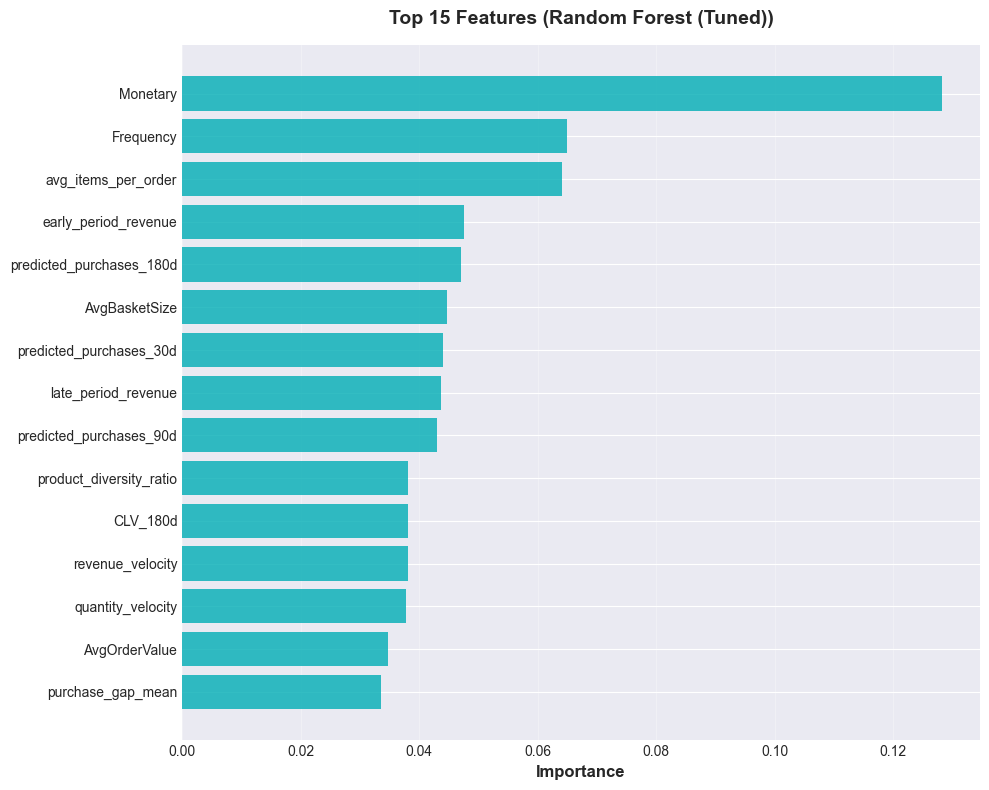


✅ Feature importance saved


In [19]:
# ┌────────────────────────────────────────────────────────────┐
# │ Feature Importance (if available)                         │
# └────────────────────────────────────────────────────────────┘

if hasattr(final_model, 'feature_importances_'):
    # Get feature importance
    importance_df = pd.DataFrame({
        'Feature': X.columns,
        'Importance': final_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print("\nTop 15 Most Important Features:")
    print("="*80)
    display(importance_df.head(15))
    
    # Visualize
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = importance_df.head(15)
    ax.barh(range(len(top_features)), top_features['Importance'], color='#00ADB5', alpha=0.8)
    ax.set_yticks(range(len(top_features)))
    ax.set_yticklabels(top_features['Feature'])
    ax.set_xlabel('Importance', fontsize=12, fontweight='bold')
    ax.set_title(f'Top 15 Features ({final_results["model_name"]})', fontsize=14, fontweight='bold', pad=15)
    ax.invert_yaxis()
    ax.grid(axis='x', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(DIR_FIGURES / '24_feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Save
    importance_df.to_csv(DIR_RESULTS / 'outputs' / 'model_feature_importance.csv', index=False)
    print("\n✅ Feature importance saved")

---

## 9. Export Results

╔════════════════════════════════════════════════════════════════╗
║                    EXPORT FINAL MODELS                          ║
╚════════════════════════════════════════════════════════════════╝

In [20]:
# ┌────────────────────────────────────────────────────────────┐
# │ Save Best Model & Scaler                                   │
# └────────────────────────────────────────────────────────────┘

# Save model
with open(DIR_MODELS / 'best_churn_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)
print("✅ Best model saved: best_churn_model.pkl")

# Save scaler
with open(DIR_MODELS / 'feature_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
print("✅ Scaler saved: feature_scaler.pkl")

# Save feature names
import json
with open(DIR_MODELS / 'feature_names.json', 'w') as f:
    json.dump(X.columns.tolist(), f, indent=2)
print("✅ Feature names saved: feature_names.json")

✅ Best model saved: best_churn_model.pkl
✅ Scaler saved: feature_scaler.pkl
✅ Feature names saved: feature_names.json


In [21]:
# ┌────────────────────────────────────────────────────────────┐
# │ Final Summary Report                                       │
# └────────────────────────────────────────────────────────────┘

summary_report = pd.DataFrame({
    'Metric': [
        'Total Models Compared',
        'Best Model',
        'Best ROC-AUC',
        'Best F1-Score',
        'Best Recall',
        'Best Precision',
        'Tuning Applied',
        'Training Samples',
        'Test Samples',
        'Number of Features',
        'Class Balance (Churn%)'
    ],
    'Value': [
        len(all_results),
        final_results['model_name'],
        f"{final_results['roc_auc']:.4f}",
        f"{final_results['f1']:.4f}",
        f"{final_results['recall']:.4f}",
        f"{final_results['precision']:.4f}",
        'Yes' if param_dist is not None else 'No',
        len(X_train),
        len(X_test),
        X.shape[1],
        f"{y.mean()*100:.1f}%"
    ]
})

summary_report.to_csv(DIR_RESULTS / 'outputs' / 'churn_modeling_summary.csv', index=False)
print("✅ Summary saved: churn_modeling_summary.csv")

print("\n" + "="*80)
print("FINAL MODEL SUMMARY")
print("="*80)
display(summary_report)

✅ Summary saved: churn_modeling_summary.csv

FINAL MODEL SUMMARY


,Metric,Value
0,Total Models Compared,6
1,Best Model,Random Forest (Tuned)
2,Best ROC-AUC,0.6469
3,Best F1-Score,0.3830
4,Best Recall,0.4091
5,Best Precision,0.3600
6,Tuning Applied,Yes
7,Training Samples,570
8,Test Samples,245
9,Number of Features,30


In [22]:
# ┌────────────────────────────────────────────────────────────┐
# │ Completion Summary                                         │
# └────────────────────────────────────────────────────────────┘

print("\n" + "═"*80)
print("SUPERVISED CHURN MODELING COMPLETE")
print("═"*80)

print("\n✅ Models Trained & Compared:")
print("   • Logistic Regression (baseline)")
print("   • Decision Tree (baseline)")
print("   • Random Forest")
print("   • LightGBM")
print("   • CatBoost")
print("   • XGBoost")

print(f"\n✅ Best Model: {final_results['model_name']}")
print(f"   ROC-AUC: {final_results['roc_auc']:.4f}")
print(f"   F1-Score: {final_results['f1']:.4f}")
print(f"   Recall: {final_results['recall']:.4f}")
print(f"   Precision: {final_results['precision']:.4f}")

print("\n✅ Outputs Created:")
print("   • models/best_churn_model.pkl")
print("   • models/feature_scaler.pkl")
print("   • models/feature_names.json")
print("   • results/model_comparison.csv")
print("   • results/model_feature_importance.csv")
print("   • results/churn_modeling_summary.csv")
print("   • results/figures/ (3 new visualizations)")

print("\n✅ Ready for:")
print("   • Explainability analysis (SHAP)")
print("   • Business strategy & ROI calculation")
print("   • Customer segmentation")
print("   • Streamlit dashboard deployment")

print("\n" + "═"*80)


════════════════════════════════════════════════════════════════════════════════
SUPERVISED CHURN MODELING COMPLETE
════════════════════════════════════════════════════════════════════════════════

✅ Models Trained & Compared:
   • Logistic Regression (baseline)
   • Decision Tree (baseline)
   • Random Forest
   • LightGBM
   • CatBoost
   • XGBoost

✅ Best Model: Random Forest (Tuned)
   ROC-AUC: 0.6469
   F1-Score: 0.3830
   Recall: 0.4091
   Precision: 0.3600

✅ Outputs Created:
   • models/best_churn_model.pkl
   • models/feature_scaler.pkl
   • models/feature_names.json
   • results/model_comparison.csv
   • results/model_feature_importance.csv
   • results/churn_modeling_summary.csv
   • results/figures/ (3 new visualizations)

✅ Ready for:
   • Explainability analysis (SHAP)
   • Business strategy & ROI calculation
   • Customer segmentation
   • Streamlit dashboard deployment

════════════════════════════════════════════════════════════════════════════════
